In [33]:
import heapq            # Usado para manter a fila de eventos como uma heap (fila de prioridade)
import random           # Para geração de números aleatórios
import matplotlib.pyplot as plt  # Para visualizações gráficas
import numpy as np      # Para operações numéricas com arrays

# Configuração de estilos dos gráficos
plt.rc('font', size=16)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=18)


In [34]:
TRANSMISSION_RATE_BPS = 10_000_000     # Taxa de transmissão (10 Mbps)
PROPAGATION_DELAY = 0.00333            # Atraso de propagação (3.33 ms)
QUEUE_SIZE_BYTES = 5000                # Capacidade máxima da fila de pacotes por estação
SIM_TIME = 20                          # Tempo total de simulação (em segundos)
PACKET_GEN_RATE_A = 100                # Taxa de geração de pacotes na estação A (Poisson)
INTERVAL_B = 0.040                     # Intervalo fixo entre pacotes na estação B


# SISTEMA DE EVENTOS

In [35]:
class Event:
    """Classe base para todos os eventos da simulação."""
    def __init__(self, time):
        self.time = time  # Tempo em que o evento ocorre

    def __lt__(self, other):
        return self.time < other.time  # Prioridade por tempo (para fila de eventos)

    def processing_event(self, simulator):
        raise NotImplementedError("Subclasses devem implementar este método.")


In [36]:
class Simulator:
    """Gerencia o tempo e execução da simulação baseada em eventos discretos."""
    def __init__(self, end_time):
        self.current_time = 0
        self.event_queue = []  # Fila de eventos (heap)
        self.end_time = end_time
        self.stations = {'A': Station('A'), 'B': Station('B')}
        self.collisions = []  # Lista de colisões
        self.exp_gen_A = ExponentialGenerator(PACKET_GEN_RATE_A)

    def schedule(self, event):
        """Agenda um novo evento para a simulação."""
        heapq.heappush(self.event_queue, event)

    def run(self):
        """Executa os eventos até o final da simulação."""
        while self.event_queue and self.current_time < self.end_time:
            event = heapq.heappop(self.event_queue)
            self.current_time = event.time
            event.processing_event(self)


# GERADORES

In [37]:
def plot_uniform_generation(n_samples=10000):
    """Gera e plota amostras da distribuição uniforme para validação."""
    gen = UniformGenerator()
    samples = np.array([gen.sample() for _ in range(n_samples)])

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.hist(samples, bins=50, density=True, alpha=0.7, color='green')
    x = np.linspace(0, 1, 200)
    plt.plot(x, np.ones_like(x), 'r-', lw=2)
    plt.title('Histograma da Geração Uniforme (0,1)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    from scipy.stats import probplot
    probplot(samples, dist="uniform", sparams=(0, 1), plot=plt)
    plt.title('QQ-plot (Uniforme)')
    plt.tight_layout()
    plt.savefig("pictures/uniforme.png")
    plt.show()


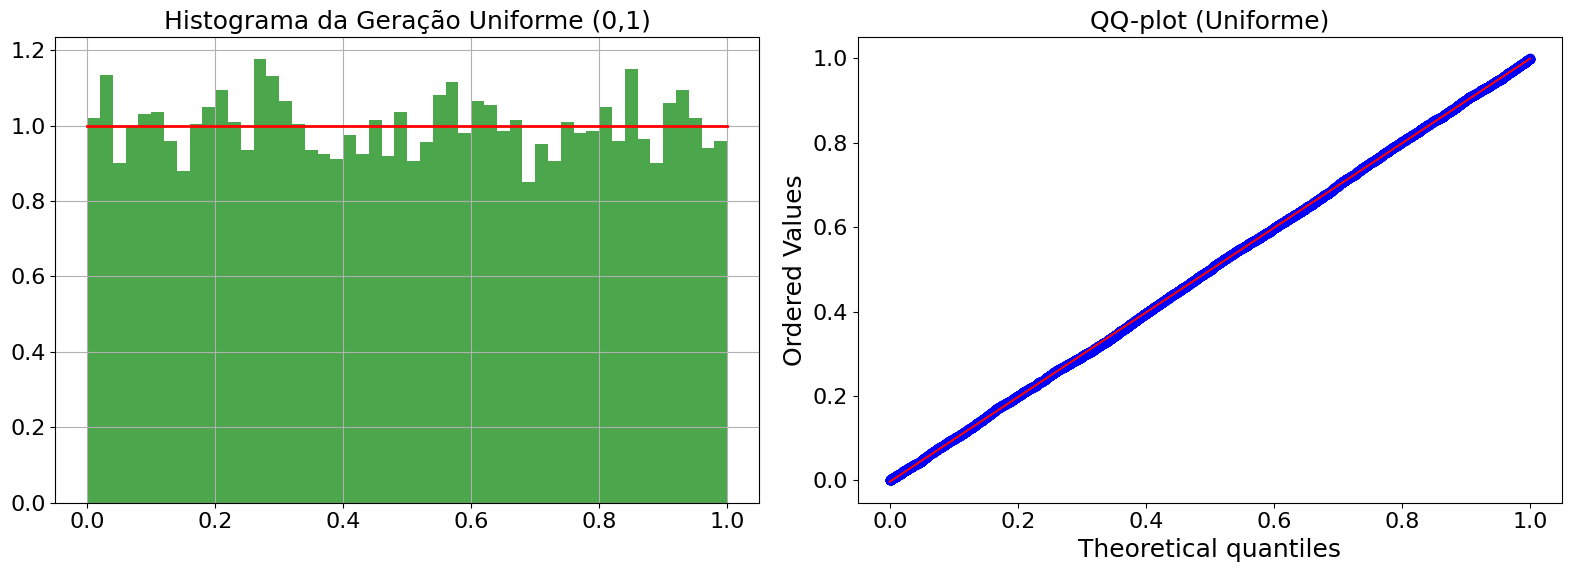

In [38]:
class UniformGenerator:
    """Gera números uniformemente distribuídos em (0,1) usando método congruencial."""
    def __init__(self, seed=123456789):
        self.modulus = 2**31 - 1
        self.a = 16807
        self.c = 0
        self.state = seed

    def sample(self):
        self.state = (self.a * self.state + self.c) % self.modulus
        return self.state / self.modulus

plot_uniform_generation(n_samples=10000)

In [39]:
def plot_exponential_generation(lambd=1.0, n_samples=10000):
    """Gera e plota amostras da distribuição exponencial para validação."""
    gen = ExponentialGenerator(lambd)
    samples = np.array([gen.sample() for _ in range(n_samples)])

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.hist(samples, bins=50, density=True, alpha=0.7, color='blue')
    x = np.linspace(0, np.max(samples), 200)
    plt.plot(x, lambd * np.exp(-lambd * x), 'r-', lw=2)
    plt.title(f'Histograma da Geração Exponencial (λ={lambd})')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    from scipy.stats import probplot
    probplot(samples, dist="expon", sparams=(0, 1/lambd), plot=plt)
    plt.title('QQ-plot (Exponencial)')
    plt.tight_layout()
    plt.savefig("pictures/exponencial.png")
    plt.show()


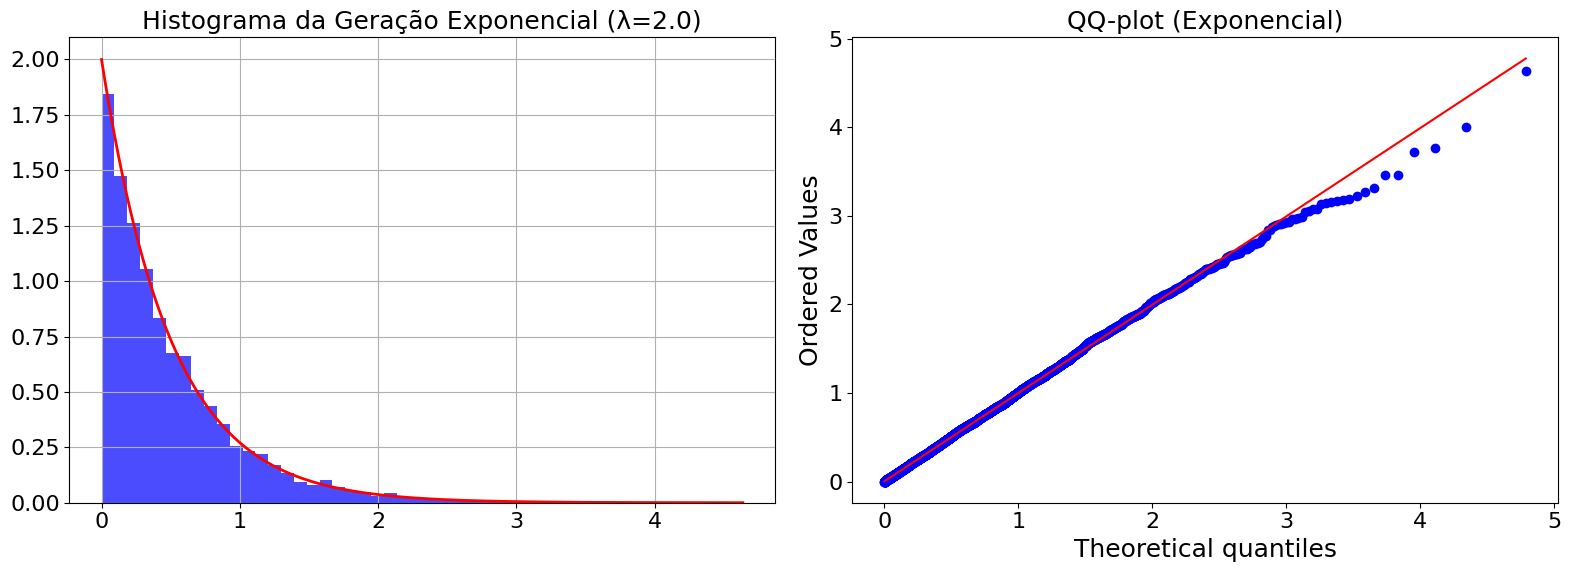

In [40]:
class ExponentialGenerator:
    """Gera números com distribuição exponencial (modelo de chegada Poisson)."""
    def __init__(self, lambd, uniform_gen=None):
        self.lambd = lambd
        self.uniform_gen = uniform_gen or UniformGenerator()

    def sample(self):
        u = self.uniform_gen.sample()
        return -1 / self.lambd * np.log(u)
    
plot_exponential_generation(lambd=2.0, n_samples=10000)


# CHEGADA DE PACOTES

In [41]:
class PacketArrivalA(Event):
    """Chegada de pacotes na estação A com distribuição Poisson."""
    def processing_event(self, sim):
        est = sim.stations['A']
        pkt_size = random.randint(20, 1000)  # Tamanho do pacote aleatório
        if est.queue_size + pkt_size <= QUEUE_SIZE_BYTES:
            est.queue.append((sim.current_time, pkt_size))
            est.queue_size += pkt_size
            if not est.transmitting:
                sim.schedule(TransmissionStart(sim.current_time, est.name))
        # Agenda próxima chegada
        next_time = sim.current_time + sim.exp_gen_A.sample()
        sim.schedule(PacketArrivalA(next_time))


In [42]:
class PacketArrivalB(Event):
    """Chegada de pacotes na estação B com intervalo fixo."""
    def processing_event(self, sim):
        est = sim.stations['B']
        pkt_size = 500
        if est.queue_size + pkt_size <= QUEUE_SIZE_BYTES:
            est.queue.append((sim.current_time, pkt_size))
            est.queue_size += pkt_size
            if not est.transmitting:
                sim.schedule(TransmissionStart(sim.current_time, est.name))
        sim.schedule(PacketArrivalB(sim.current_time + INTERVAL_B))


# TRANSMISSÃO DE PACOTES

In [43]:
class TransmissionStart(Event):
    """Início de uma transmissão de pacote."""
    def __init__(self, time, station_name):
        super().__init__(time)
        self.station_name = station_name

    def processing_event(self, sim):
        est = sim.stations[self.station_name]
        if not est.queue:
            return

        # Detecta colisão
        for other_name, other in sim.stations.items():
            if other_name != self.station_name and other.transmitting and \
               abs(sim.current_time - other.tx_start_time) < PROPAGATION_DELAY:
                sim.collisions.append(sim.current_time)
                est.backoffs += 1
                est.backoff_times.append(sim.current_time)
                other.backoffs += 1
                other.backoff_times.append(sim.current_time)
                est.transmitting = False
                other.transmitting = False
                sim.schedule(Backoff(sim.current_time + est.next_backoff_time(), self.station_name))
                sim.schedule(Backoff(sim.current_time + other.next_backoff_time(), other_name))
                return

        # Inicia transmissão
        pkt_time = est.queue[0][1] * 8 / TRANSMISSION_RATE_BPS
        est.transmitting = True
        est.tx_start_time = sim.current_time
        sim.schedule(TransmissionEnd(sim.current_time + pkt_time, self.station_name))


In [44]:
class TransmissionEnd(Event):
    """Término da transmissão de um pacote."""
    def __init__(self, time, station_name):
        super().__init__(time)
        self.station_name = station_name

    def processing_event(self, sim):
        est = sim.stations[self.station_name]
        if est.queue:
            start_time, pkt_size = est.queue.pop(0)
            est.queue_size -= pkt_size
            est.bytes_sent += pkt_size
            est.tx_history.append((sim.current_time, pkt_size * 8))
        est.transmitting = False
        if est.queue:
            sim.schedule(TransmissionStart(sim.current_time, self.station_name))


# MODELO DE ESTAÇÃO

In [45]:
class Station:
    """Modela uma estação (A ou B) com fila e estado de transmissão."""
    def __init__(self, name):
        self.name = name
        self.queue = []             # Fila de pacotes (tupla: tempo, tamanho)
        self.queue_size = 0
        self.transmitting = False
        self.tx_start_time = 0
        self.bytes_sent = 0
        self.backoffs = 0
        self.backoff_times = []     # Registro dos tempos de colisão
        self.tx_history = []        # Registro das transmissões

    def next_backoff_time(self):
        """Gera um tempo aleatório de espera (backoff)."""
        return random.uniform(0.001, 0.01)


# VISUALIZAÇÃO DOS RESULTADOS

In [46]:
def plot_results(sim):
    """Plota gráficos de colisões, vazão e backoffs ao longo do tempo."""
    bin_width = 0.5
    bins = np.arange(0, SIM_TIME + bin_width, bin_width)

    # --- 1. Colisões ---
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 1, 1)
    plt.hist(sim.collisions, bins=bins, color="red", alpha=0.7)
    plt.title("Colisões por intervalo de tempo")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Nº de colisões")
    plt.grid(True)

    plt.subplot(2, 1, 2)
    sorted_collisions = sorted(sim.collisions)
    counts = np.arange(1, len(sorted_collisions) + 1)
    plt.plot(sorted_collisions, counts, color="blue")
    plt.title("Colisões acumuladas ao longo do tempo")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Total de colisões")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("pictures/colisoes.png")
    plt.show()

    # --- 2. Vazão ---
    plt.figure(figsize=(16, 9))
    for name, station in sim.stations.items():
        tx_times, bits = zip(*station.tx_history) if station.tx_history else ([0], [0])
        bits_per_bin = np.histogram(tx_times, bins=bins, weights=bits)[0]
        mbytes_per_bin = bits_per_bin / 8 / 1_000
        throughput_MBps = mbytes_per_bin / bin_width
        plt.plot(bins[:-1], throughput_MBps, label=f'Estação {name}')
    plt.title("Vazão de cada estação ao longo do tempo")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Vazão (KB/s)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("pictures/vazao.png")
    plt.show()

    # --- 3. Backoffs ---
    plt.figure(figsize=(16, 9))
    for name, station in sim.stations.items():
        backoff_times = station.backoff_times
        backoffs_per_bin = np.histogram(backoff_times, bins=bins)[0]
        plt.plot(bins[:-1], backoffs_per_bin, label=f'Estação {name}')
    plt.title("Backoffs ao longo do tempo")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Nº de backoffs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("pictures/backoffs.png")
    plt.show()


# FUNÇÃO PRINCIPAL

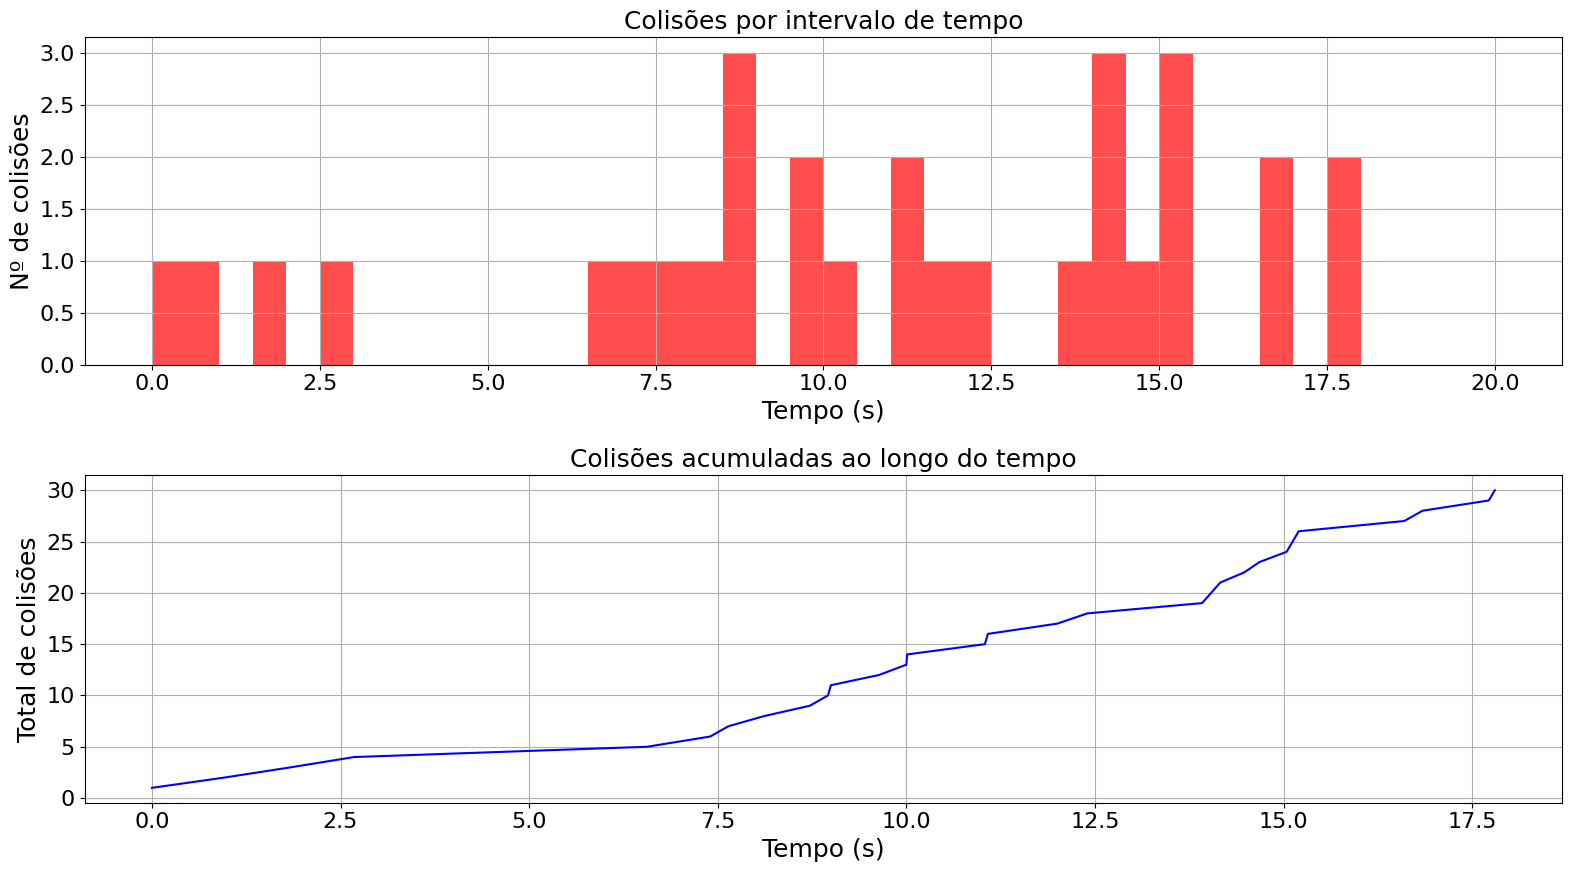

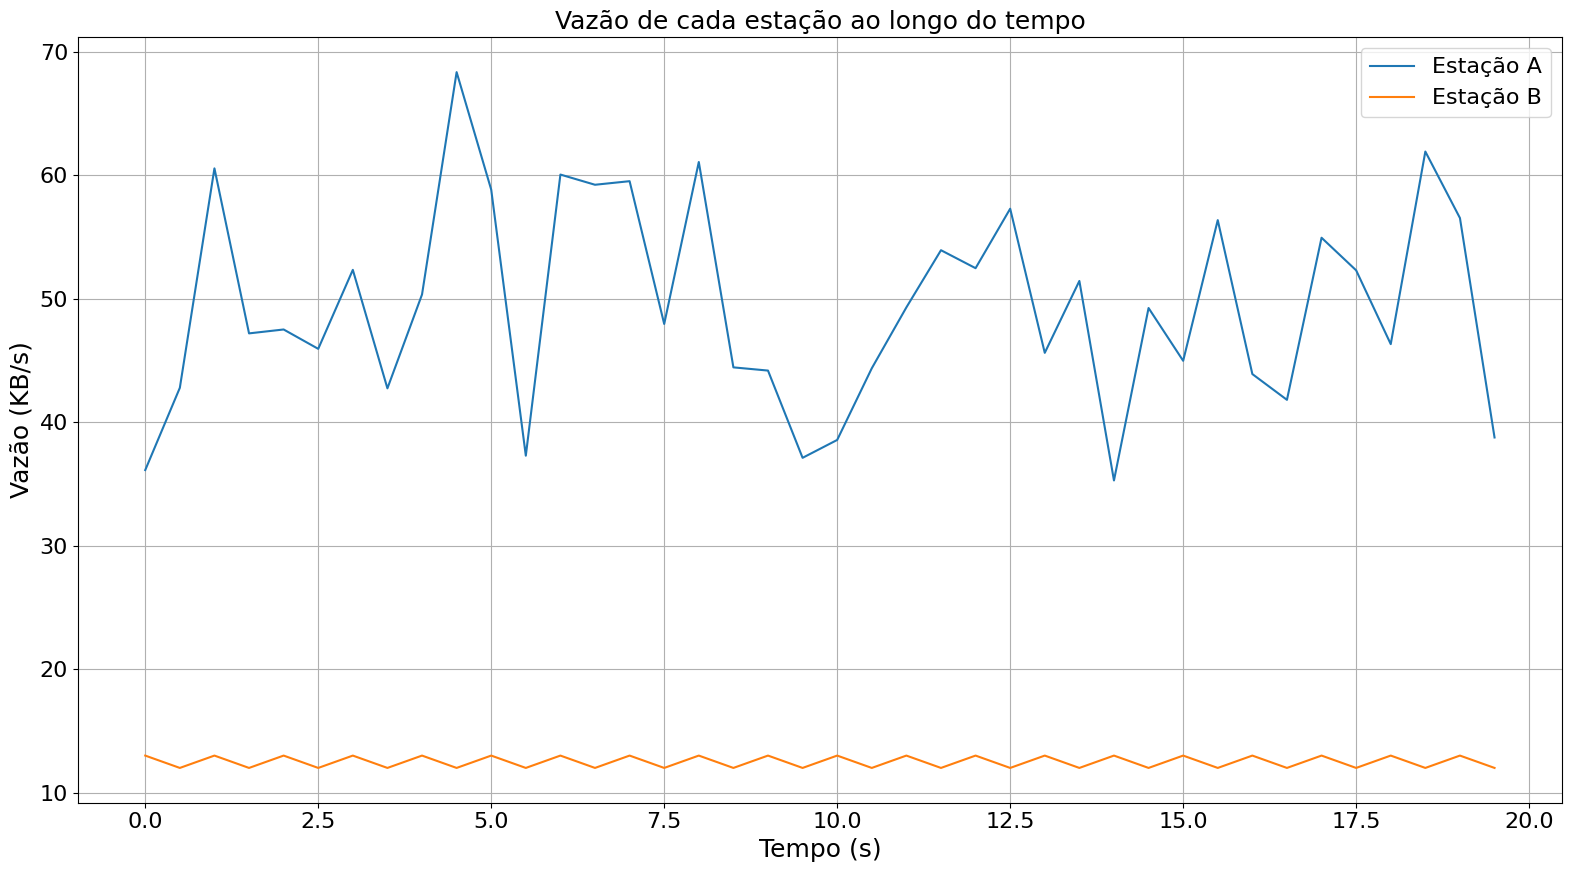

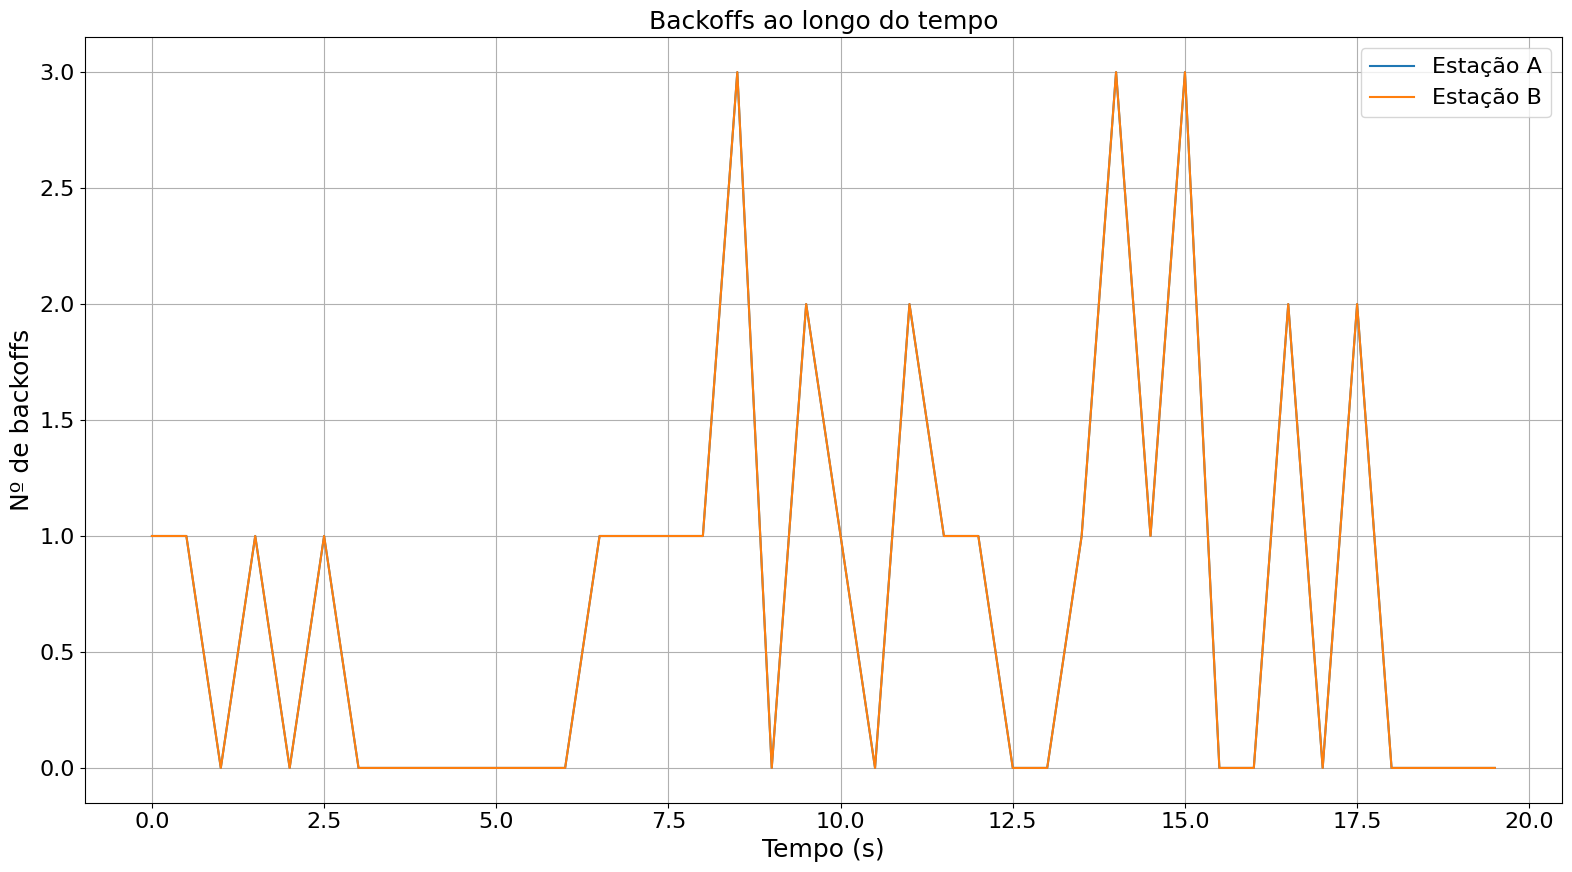

In [47]:
def main():
    """Inicia a simulação, agenda os eventos e plota os resultados."""
    sim = Simulator(SIM_TIME)
    # Injeta primeiro pacote manualmente na estação A
    first_pkt_size = random.randint(20, 1000)
    est_a = sim.stations['A']
    est_a.queue.append((0, first_pkt_size))
    est_a.queue_size += first_pkt_size
    sim.schedule(TransmissionStart(0, 'A'))

    # Agenda as chegadas de pacotes
    sim.schedule(PacketArrivalA(0))
    sim.schedule(PacketArrivalB(0))

    # Executa a simulação
    sim.run()

    # Plota os resultados
    plot_results(sim)

# Executa o script
if __name__ == "__main__":
    main()

